In [1]:
import os, random, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from typing import List, Dict

import cv2
import torch

In [2]:
!pip freeze > /kaggle/working/requirements.txt

In [3]:
SEED = 42

def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
ROOT_PATH = "/kaggle/input/original-size-vindr-mammo/images_processed_cv2_dicomsdl_originalsize"

META_DATA = "/kaggle/input/vindr-mammo-annotations/metadata.csv"
BREAST_LEVEL_DATA = "/kaggle/input/vindr-mammo-annotations/breast-level_annotations.csv"
FINDING_ANNOTATIONS_DATA = "/kaggle/input/vindr-mammo-annotations/finding_annotations.csv"

In [6]:
annotations_df = pd.read_csv(FINDING_ANNOTATIONS_DATA)

In [7]:
def string_to_list(df_col: pd.core.series.Series = annotations_df["finding_categories"]) -> List[List[str]]:
    new_df_col = []
    string_to_list = lambda string: [elem.strip("\"' ") for elem in string.strip("[]").split(",")]
    for cat in df_col:
        new_df_col.append(string_to_list(cat))
    return new_df_col

In [8]:
#annotations_df["finding_categories"] = string_to_list()
annotations_df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Architectural Distortion'],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training


In [9]:
selected_mass = annotations_df[annotations_df.finding_categories == "['Mass']"]
selected_mass.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training
6,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2171.810059,439.584991,2403.370117,test
7,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2045.170044,417.876007,2265.879883,test
10,89524e5f372d9aff8ed43b4ef29c1435,0838a0b906894e0cc06c993426a2d143,5a94dd668eaa9865b907450c37db6ecc,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,1988.060059,1793.739990,2139.909912,1967.459961,training


In [10]:
def create_path_col(df: pd.core.frame.DataFrame = selected_mass) -> List[str]:
    path_col = []
    for idx, data_row in tqdm(df.iterrows(), total=len(df)):
        study_id = str(data_row["study_id"])
        image_id = str(data_row["image_id"])
        patient_dir =  os.path.join(ROOT_PATH, study_id)
        image_name = image_id + ".png"
        image_path = os.path.join(patient_dir, image_name)
        path_col.append(image_path)
    return path_col

In [11]:
selected_mass["image_path"] = create_path_col()

100%|██████████| 1123/1123 [00:00<00:00, 12498.65it/s]
/tmp/ipykernel_33/679242453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_mass["image_path"] = create_path_col()


In [12]:
selected_mass.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,image_path
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training,/kaggle/input/original-size-vindr-mammo/images...
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training,/kaggle/input/original-size-vindr-mammo/images...
6,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2171.810059,439.584991,2403.370117,test,/kaggle/input/original-size-vindr-mammo/images...
7,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2045.170044,417.876007,2265.879883,test,/kaggle/input/original-size-vindr-mammo/images...
10,89524e5f372d9aff8ed43b4ef29c1435,0838a0b906894e0cc06c993426a2d143,5a94dd668eaa9865b907450c37db6ecc,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,1988.060059,1793.739990,2139.909912,1967.459961,training,/kaggle/input/original-size-vindr-mammo/images...


In [13]:
selected_mass.split.value_counts()

split
training    905
test        218
Name: count, dtype: int64

In [14]:
# there are images that do not have any annotations, drop them for model
print(len(selected_mass[selected_mass.xmin.isna()].index) == sum(selected_mass[selected_mass.xmin.isna()].index == selected_mass[selected_mass.ymin.isna()].index))
print(len(selected_mass[selected_mass.xmax.isna()].index) == sum(selected_mass[selected_mass.xmax.isna()].index == selected_mass[selected_mass.ymax.isna()].index))

True
True


In [15]:
# BIRADS 1-2
selected_mass_benign = selected_mass[selected_mass.xmin.isna()].reset_index(drop=True)
selected_mass_benign.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,image_path


In [16]:
# there are no benign 1-2 birads
selected_mass_benign.breast_birads.value_counts()

Series([], Name: count, dtype: int64)

In [17]:
# BIRADS 3-4-5
selected_mass_malignant = selected_mass[~selected_mass.xmin.isna()].reset_index(drop=True)
selected_mass_malignant.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,image_path
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training,/kaggle/input/original-size-vindr-mammo/images...
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training,/kaggle/input/original-size-vindr-mammo/images...
2,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2171.810059,439.584991,2403.370117,test,/kaggle/input/original-size-vindr-mammo/images...
3,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2045.170044,417.876007,2265.879883,test,/kaggle/input/original-size-vindr-mammo/images...
4,89524e5f372d9aff8ed43b4ef29c1435,0838a0b906894e0cc06c993426a2d143,5a94dd668eaa9865b907450c37db6ecc,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,1988.060059,1793.739990,2139.909912,1967.459961,training,/kaggle/input/original-size-vindr-mammo/images...


In [18]:
selected_mass_malignant.finding_birads.value_counts()

finding_birads
BI-RADS 3    566
BI-RADS 4    453
BI-RADS 5    104
Name: count, dtype: int64

In [19]:
selected_mass_malignant.breast_birads.value_counts()

breast_birads
BI-RADS 3    528
BI-RADS 4    445
BI-RADS 5    150
Name: count, dtype: int64

In [20]:
selected_mass_malignant.finding_birads.value_counts()

finding_birads
BI-RADS 3    566
BI-RADS 4    453
BI-RADS 5    104
Name: count, dtype: int64

In [21]:
# convert/scale/adjust annotation points to current one
original_height, original_width = selected_mass["height"][0], selected_mass["width"][0]

rescaled_xmin = int(selected_mass["xmin"].iloc[0])
rescaled_ymin = int(selected_mass["ymin"].iloc[0])
rescaled_xmax = int(selected_mass["xmax"].iloc[0])
rescaled_ymax = int(selected_mass["ymax"].iloc[0])

In [22]:
xx = (rescaled_xmin + rescaled_xmax) / 2
yy = (rescaled_ymin + rescaled_ymax) / 2
ww = rescaled_xmax - rescaled_xmin
hh = rescaled_ymax - rescaled_ymin

(xx - ww / 2, yy - hh / 2),(xx + ww / 2, yy + hh / 2)

((2355.0, 1731.0), (2482.0, 1852.0))

In [23]:
meta_df = pd.read_csv("/kaggle/input/vindr-mammo-annotations/metadata.csv")
meta_df.columns

Index(['SOP Instance UID', 'Series Instance UID', 'SOP Instance UID.1',
       'Patient's Age', 'View Position', 'Image Laterality',
       'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing',
       'Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit',
       'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope',
       'Rescale Type', 'Window Center & Width Explanation', 'Manufacturer',
       'Manufacturer's Model Name'],
      dtype='object')

In [24]:
annotations_df = selected_mass.reset_index(drop=True)

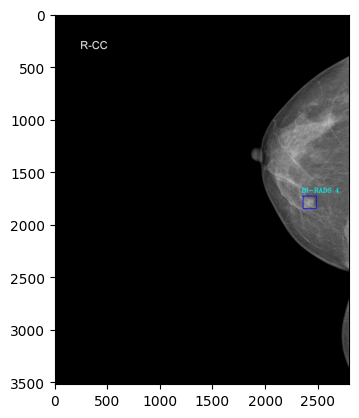

In [25]:
# convert/scale/adjust annotation points to current one
original_height, original_width = annotations_df["height"][0], annotations_df["width"][0]

rescaled_xmin = int(annotations_df["xmin"].iloc[0])
rescaled_ymin = int(annotations_df["ymin"].iloc[0])
rescaled_xmax = int(annotations_df["xmax"].iloc[0])
rescaled_ymax = int(annotations_df["ymax"].iloc[0])
xx = (rescaled_xmin + rescaled_xmax) // 2
yy = (rescaled_ymin + rescaled_ymax) // 2
ww = rescaled_xmax - rescaled_xmin
hh = rescaled_ymax - rescaled_ymin

# visualize a sample image and annotation
sample = plt.imread(annotations_df["image_path"][0])
sample_bgr = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)

# Draw rectangle around the annotated area
cv2.rectangle(sample_bgr,
              (int(xx - (ww / 2)), int(yy - (hh / 2))),
              (int(xx + (ww / 2)), int(yy + (hh / 2))),
              (255, 0, 0), 5)

# Add text to the image
cv2.putText(sample_bgr, annotations_df["finding_birads"][0], (rescaled_xmin-15, rescaled_ymin-35),
            cv2.FONT_HERSHEY_COMPLEX, 2, (255, 200, 0), 3, cv2.LINE_AA)

# Display the annotated image
plt.imshow(cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2RGB), cmap="bone")
plt.show()

In [26]:
import pandas as pd

def add_points(df: pd.core.frame.DataFrame = annotations_df):
    x_centers, y_centers = [], []
    ann_widths, ann_heights = [], []
    
    for i in range(df.shape[0]):
        original_height, original_width = df["height"][i], df["width"][i]

        rescaled_xmin = df["xmin"].iloc[i]
        rescaled_ymin = df["ymin"].iloc[i]
        rescaled_xmax = df["xmax"].iloc[i]
        rescaled_ymax = df["ymax"].iloc[i]
        
        x_center = (rescaled_xmax + rescaled_xmin) / 2
        y_center = (rescaled_ymax + rescaled_ymin) / 2
        ann_width = (rescaled_xmax - rescaled_xmin)
        ann_height = (rescaled_ymax - rescaled_ymin)

        x_centers.append(x_center / original_width)
        y_centers.append(y_center / original_height)
        ann_widths.append(ann_width / original_width)
        ann_heights.append(ann_height / original_height)
    
    rescaled_bboxes = {
        "x_centers": x_centers,
        "y_centers": y_centers,
        "ann_widths": ann_widths,
        "ann_heights": ann_heights,
    }
    
    return rescaled_bboxes

bboxes = add_points()

annotations_df["x_centers"] = bboxes["x_centers"]
annotations_df["y_centers"] = bboxes["y_centers"]
annotations_df["ann_widths"] = bboxes["ann_widths"]
annotations_df["ann_heights"] = bboxes["ann_heights"]

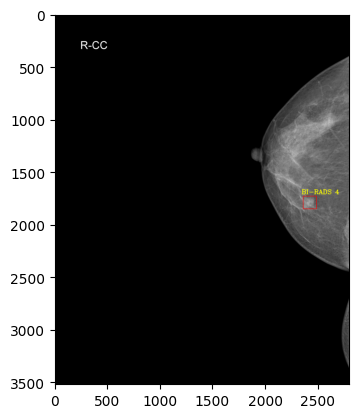

In [27]:
# visualize a sample image and annotation
sample = plt.imread(annotations_df["image_path"][0])
sample_bgr = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)

original_w = annotations_df["width"][0]
original_h = annotations_df["height"][0]

# Calculate rectangle coordinates
xmin = int((annotations_df["x_centers"][0] - annotations_df["ann_widths"][0] / 2) * original_w) 
ymin = int((annotations_df["y_centers"][0] - annotations_df["ann_heights"][0] / 2) * original_h)
xmax = int((annotations_df["x_centers"][0] + annotations_df["ann_widths"][0] / 2) * original_w) 
ymax = int((annotations_df["y_centers"][0] + annotations_df["ann_heights"][0] / 2) * original_h) 

# Draw rectangle around the annotated area
cv2.rectangle(sample_bgr, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)

# Add text to the image
text_x = int((annotations_df["x_centers"][0] - annotations_df["ann_widths"][0] / 2) * original_w - 15) 
text_y = int((annotations_df["y_centers"][0] - annotations_df["ann_heights"][0] / 2) * original_h - 20) 
cv2.putText(sample_bgr, annotations_df["finding_birads"][0], (text_x, text_y), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 200, 0), 3, cv2.LINE_AA)

plt.imshow(sample_bgr, cmap="bone")

In [28]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {
                           "BI-RADS 3": 0,
                           "BI-RADS 4": 1,
                           "BI-RADS 5": 2,
                           }

In [29]:
annotations_df["class_id"] = [class_name_to_id_mapping[bf] for bf in annotations_df["breast_birads"]] 

In [30]:
annotations_df.finding_categories.value_counts()

finding_categories
['Mass']    1123
Name: count, dtype: int64

In [31]:
annotations_df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,...,ymin,xmax,ymax,split,image_path,x_centers,y_centers,ann_widths,ann_heights,class_id
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],...,1731.640015,2482.979980,1852.750000,training,/kaggle/input/original-size-vindr-mammo/images...,0.863950,0.509436,0.045657,0.034426,1
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],...,1240.609985,2501.800049,1354.040039,training,/kaggle/input/original-size-vindr-mammo/images...,0.872943,0.368768,0.041114,0.032243,1
2,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],...,2171.810059,439.584991,2403.370117,test,/kaggle/input/original-size-vindr-mammo/images...,0.104015,0.650253,0.105959,0.065822,0
3,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],...,2045.170044,417.876007,2265.879883,test,/kaggle/input/original-size-vindr-mammo/images...,0.100138,0.612713,0.098206,0.062737,0
4,89524e5f372d9aff8ed43b4ef29c1435,0838a0b906894e0cc06c993426a2d143,5a94dd668eaa9865b907450c37db6ecc,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],...,1793.739990,2139.909912,1967.459961,training,/kaggle/input/original-size-vindr-mammo/images...,0.737137,0.534565,0.054232,0.049380,0


In [32]:
annotations_df[annotations_df.breast_birads.isna()]

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,...,ymin,xmax,ymax,split,image_path,x_centers,y_centers,ann_widths,ann_heights,class_id


In [33]:
annotations_df.breast_birads.value_counts()

breast_birads
BI-RADS 3    528
BI-RADS 4    445
BI-RADS 5    150
Name: count, dtype: int64

In [34]:
tmp_df = annotations_df.drop_duplicates(subset=["image_id"]).reset_index(drop=True)
tmp_df["breast_birads"] = annotations_df.groupby("image_id")["breast_birads"].agg(list).reset_index(drop=True)
tmp_df["class_id"] = annotations_df.groupby("image_id")["class_id"].agg(list).reset_index(drop=True)

In [35]:
tmp_df.shape, annotations_df.shape

((1029, 22), (1123, 22))

In [36]:
# grouby image_id is important. there was a bug when grouped by study_id -> NaN bboxes...
tmp_df["bboxes"] = annotations_df.groupby("image_id").apply(lambda x: x[["x_centers", "y_centers", "ann_widths", "ann_heights"]].values.tolist()).reset_index(drop=True)

/tmp/ipykernel_33/3792428698.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp_df["bboxes"] = annotations_df.groupby("image_id").apply(lambda x: x[["x_centers", "y_centers", "ann_widths", "ann_heights"]].values.tolist()).reset_index(drop=True)


In [37]:
tmp_df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,...,xmax,ymax,split,image_path,x_centers,y_centers,ann_widths,ann_heights,class_id,bboxes
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,[BI-RADS 4],DENSITY C,['Mass'],...,2482.979980,1852.750000,training,/kaggle/input/original-size-vindr-mammo/images...,0.863950,0.509436,0.045657,0.034426,[1],"[[0.7778014298494508, 0.6158526001469499, 0.21..."
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,[BI-RADS 3],DENSITY C,['Mass'],...,2501.800049,1354.040039,training,/kaggle/input/original-size-vindr-mammo/images...,0.872943,0.368768,0.041114,0.032243,[0],"[[0.06340214082172875, 0.5807873680891131, 0.1..."
2,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,3518,2800,[BI-RADS 3],DENSITY C,['Mass'],...,439.584991,2403.370117,test,/kaggle/input/original-size-vindr-mammo/images...,0.104015,0.650253,0.105959,0.065822,[0],"[[0.047059193757135936, 0.5962411112669985, 0...."
3,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,3518,2800,[BI-RADS 4],DENSITY C,['Mass'],...,417.876007,2265.879883,test,/kaggle/input/original-size-vindr-mammo/images...,0.100138,0.612713,0.098206,0.062737,[1],"[[0.054891357421875536, 0.529475556374133, 0.0..."
4,89524e5f372d9aff8ed43b4ef29c1435,0838a0b906894e0cc06c993426a2d143,5a94dd668eaa9865b907450c37db6ecc,R,CC,3518,2800,[BI-RADS 4],DENSITY C,['Mass'],...,2139.909912,1967.459961,training,/kaggle/input/original-size-vindr-mammo/images...,0.737137,0.534565,0.054232,0.049380,[1],"[[0.12869753658197366, 0.632834230852759, 0.10..."


In [38]:
tmp_df[tmp_df.bboxes.isna()]

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,...,xmax,ymax,split,image_path,x_centers,y_centers,ann_widths,ann_heights,class_id,bboxes


In [39]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   study_id            1029 non-null   object 
 1   series_id           1029 non-null   object 
 2   image_id            1029 non-null   object 
 3   laterality          1029 non-null   object 
 4   view_position       1029 non-null   object 
 5   height              1029 non-null   int64  
 6   width               1029 non-null   int64  
 7   breast_birads       1029 non-null   object 
 8   breast_density      1029 non-null   object 
 9   finding_categories  1029 non-null   object 
 10  finding_birads      1029 non-null   object 
 11  xmin                1029 non-null   float64
 12  ymin                1029 non-null   float64
 13  xmax                1029 non-null   float64
 14  ymax                1029 non-null   float64
 15  split               1029 non-null   object 
 16  image_

In [40]:
# we can use one of them to label
tmp_df["breast_birads"].value_counts()

breast_birads
[BI-RADS 3]                                     478
[BI-RADS 4]                                     357
[BI-RADS 5]                                     117
[BI-RADS 3, BI-RADS 3]                           25
[BI-RADS 4, BI-RADS 4]                           24
[BI-RADS 5, BI-RADS 5]                           15
[BI-RADS 4, BI-RADS 4, BI-RADS 4]                 8
[BI-RADS 4, BI-RADS 4, BI-RADS 4, BI-RADS 4]      4
[BI-RADS 5, BI-RADS 5, BI-RADS 5]                 1
Name: count, dtype: int64

In [41]:
def create_info_dict(df: pd.core.frame.DataFrame = annotations_df):
    annotations = []
    #os.makedirs('/kaggle/working/annotations', exist_ok=True)
    
    for i in range(df.shape[0]):
        objects = []
        
        # Extracting bounding box information
        x_center = df["x_centers"].iloc[i]
        y_center = df["y_centers"].iloc[i]
        ann_width = df["ann_widths"].iloc[i]
        ann_height = df["ann_heights"].iloc[i]
        #class_id = df["class_id"].iloc[i]
        class_id = 0 # just class of mass 
        
        # Calculate bounding box coordinates
        xmin = x_center - ann_width / 2
        ymin = y_center - ann_height / 2
        xmax = x_center + ann_width / 2
        ymax = y_center + ann_height / 2
        
        # Constructing object dictionary
        obj = {
            "bbox": [[x_center, y_center, ann_width, ann_height]],
            #"bbox": [[x_center, y_center, ann_width, ann_height]],
            "class_id": [class_id],
        }
        objects.append(obj)
        
        # Extracting file name
        file_name = "/".join(df["image_path"][i].split("/")[5:])
        
        # Extracting image size
        img_size = (df["height"].iloc[0], df["width"].iloc[0], 3)  # Assuming 3 channels
        
        # Constructing annotation dictionary
        annotation = {
            "objects": objects,
            "file_name": file_name,
            "image_size": img_size
        }
        
        annotations.append(annotation)
    
    return annotations

In [42]:
annnotations = create_info_dict()
len(annnotations)

1123

In [43]:
annnotations[0]

{'objects': [{'bbox': [[0.8639499773298036,
     0.5094357610358727,
     0.04565717424667858,
     0.034425805955542926]],
   'class_id': [0]}],
 'file_name': '48575a27b7c992427041a82fa750d3fa/4e3a578fe535ea4f5258d3f7f4419db8.png',
 'image_size': (3518, 2800, 3)}

In [44]:
annnotations[42]

{'objects': [{'bbox': [[0.8470731898716607,
     0.6070736380311967,
     0.06171787806917856,
     0.048570243657617966]],
   'class_id': [0]}],
 'file_name': 'd51872cb860414480dbedb3733e70724/73dcab1172639ae173f533e072daf2a4.png',
 'image_size': (3518, 2800, 3)}

In [45]:
#import shutil
#shutil.rmtree("/kaggle/working/annotations")

In [46]:
def convert_to_yolov5(info_dict: Dict[str, List[Dict[str, any]]] = annnotations) -> None:
    
    # Create directory if it doesn't exist
    save_directory = "/kaggle/working/annotations"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    for patient in tqdm(info_dict, total=len(info_dict)):
        # For each bounding box
        print_buffer = []  # Initialize print_buffer for each patient

        objects = patient["objects"][0]
        img_size = patient["image_size"]
        file_name = patient["file_name"]
        
        for bbox, category in zip(objects["bbox"], objects["class_id"]):
            b_center_x = bbox[0]
            b_center_y = bbox[1]
            b_width = bbox[2]
            b_height = bbox[3]
            

            # Write the bbox details to the file
            print_buffer.append("{} {:.6f} {:.6f} {:.6f} {:.6f}".format(category, b_center_x, b_center_y, b_width, b_height))

        # Name of the file which we have to save
        save_file_name = os.path.join(save_directory, file_name.replace("png", "txt"))

        # Save the annotation to disk
        os.makedirs(os.path.dirname(save_file_name), exist_ok=True)
        with open(save_file_name, "w") as f:
            f.write("\n".join(print_buffer))

# Call the function with your info_dict
convert_to_yolov5()

100%|██████████| 1123/1123 [00:00<00:00, 8377.18it/s]


In [47]:
with open("/kaggle/working/annotations/cc2fa527db72082028747b8f14c3d578/9be8f8e91569f85bf8472c9eacc47753.txt", "r") as f:
    print(f.readlines())

['0 0.180689 0.449355 0.149038 0.149793']


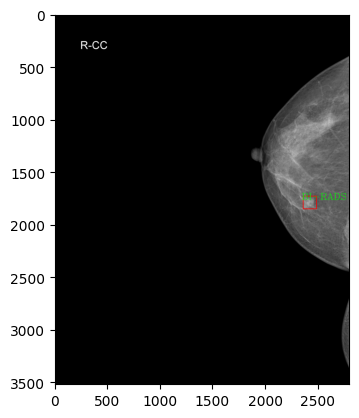

In [48]:
# check sanity !!!
# visualize a sample image and annotation
sample = plt.imread(annotations_df["image_path"][0])
sample_bgr = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)

original_w = annotations_df["width"][0]
original_h = annotations_df["height"][0]

with open(f"/kaggle/working/annotations/{annotations_df.study_id[0]}/{annotations_df.image_id[0]}.txt") as ann:
    anns = ann.readlines()[0].split()
    class_id = str(anns[0])
    x_cen = float(anns[1])
    y_cen = float(anns[2])
    w = float(anns[3])
    h = float(anns[4])

# Calculate rectangle coordinates
xmin = int((x_cen - (w / 2)) * original_w)
ymin = int((y_cen - (h / 2)) * original_h)
xmax = int((x_cen + (w / 2)) * original_w)
ymax = int((y_cen + (h / 2)) * original_h)

# Draw rectangle around the annotated area
cv2.rectangle(sample_bgr, (xmin, ymin), (xmax, ymax), (255, 0, 0), 5)

# Add text to the image
text_x = int(xmin - 15)
text_y = int(ymin + 35)
cv2.putText(sample_bgr, annotations_df["finding_birads"][0], (text_x, text_y), cv2.FONT_HERSHEY_COMPLEX, 3, (0, 255, 0), 2, cv2.LINE_AA)

plt.imshow(sample_bgr, cmap="bone")

In [49]:
ann_paths = []
for i in range(tmp_df.shape[0]):
    split_type = tmp_df["split"][i]
    study_id = tmp_df["study_id"][i]
    image_id = tmp_df["image_id"][i]
    ann_path = "/kaggle/working/annotations" + "/" + study_id + "/" + image_id + ".txt"
    ann_paths.append(ann_path)
    
tmp_df["ann_paths"] = ann_paths

In [50]:
tmp_df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,...,ymax,split,image_path,x_centers,y_centers,ann_widths,ann_heights,class_id,bboxes,ann_paths
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,[BI-RADS 4],DENSITY C,['Mass'],...,1852.750000,training,/kaggle/input/original-size-vindr-mammo/images...,0.863950,0.509436,0.045657,0.034426,[1],"[[0.7778014298494508, 0.6158526001469499, 0.21...",/kaggle/working/annotations/48575a27b7c9924270...
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,[BI-RADS 3],DENSITY C,['Mass'],...,1354.040039,training,/kaggle/input/original-size-vindr-mammo/images...,0.872943,0.368768,0.041114,0.032243,[0],"[[0.06340214082172875, 0.5807873680891131, 0.1...",/kaggle/working/annotations/48575a27b7c9924270...
2,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,3518,2800,[BI-RADS 3],DENSITY C,['Mass'],...,2403.370117,test,/kaggle/input/original-size-vindr-mammo/images...,0.104015,0.650253,0.105959,0.065822,[0],"[[0.047059193757135936, 0.5962411112669985, 0....",/kaggle/working/annotations/5683854eafabc34f6d...
3,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,3518,2800,[BI-RADS 4],DENSITY C,['Mass'],...,2265.879883,test,/kaggle/input/original-size-vindr-mammo/images...,0.100138,0.612713,0.098206,0.062737,[1],"[[0.054891357421875536, 0.529475556374133, 0.0...",/kaggle/working/annotations/5683854eafabc34f6d...
4,89524e5f372d9aff8ed43b4ef29c1435,0838a0b906894e0cc06c993426a2d143,5a94dd668eaa9865b907450c37db6ecc,R,CC,3518,2800,[BI-RADS 4],DENSITY C,['Mass'],...,1967.459961,training,/kaggle/input/original-size-vindr-mammo/images...,0.737137,0.534565,0.054232,0.049380,[1],"[[0.12869753658197366, 0.632834230852759, 0.10...",/kaggle/working/annotations/89524e5f372d9aff8e...


In [51]:
train_df = tmp_df[tmp_df.split == "training"].reset_index(drop=True)
test_df = tmp_df[tmp_df.split == "test"].reset_index(drop=True)

In [52]:
train_images, train_annotations = train_df["image_path"], train_df["ann_paths"]

In [53]:
test_images, test_annotations = test_df["image_path"], test_df["ann_paths"]

In [54]:
assert len(train_images) == len(train_annotations)
assert len(test_images) == len(test_annotations)

In [55]:
os.makedirs("/kaggle/working/images/training", exist_ok=True) 
os.makedirs("/kaggle/working/images/test", exist_ok=True) 
os.makedirs("/kaggle/working/labels/training", exist_ok=True) 
os.makedirs("/kaggle/working/labels/test", exist_ok=True) 

In [56]:
def move_files_to_folder(list_of_files, destination_folder, is_image: bool = True):
    for f in tqdm(list_of_files):
        try:
            if is_image:
                shutil.copy(f, destination_folder)
            else:
                # Check if destination folder exists
                if not os.path.exists(destination_folder):
                    os.makedirs(destination_folder)
                
                # Get the file name from the source path
                file_name = os.path.basename(f)
                
                # Destination path
                destination_path = os.path.join(destination_folder, file_name)
                
                # If destination file exists, append the text to it
                if os.path.exists(destination_path):
                    with open(destination_path, "a") as dest_file:
                        dest_file.write("\n")
                        with open(f, "r") as src_file:
                            dest_file.write(src_file.read())
                else:
                    shutil.move(f, destination_path)
        except shutil.Error as e:
            print(f"Skipping file {f}: {e}")

# Move the splits into their folders
move_files_to_folder(train_images, '/kaggle/working/images/training')
move_files_to_folder(test_images, '/kaggle/working/images/test/')
move_files_to_folder(train_annotations, '/kaggle/working/labels/training/', is_image=False)
move_files_to_folder(test_annotations, '/kaggle/working/labels/test/', is_image=False)

100%|██████████| 206/206 [00:00<00:00, 20508.58it/s]


In [57]:
assert len(os.listdir("/kaggle/working/images/training/")) == len(os.listdir("/kaggle/working/labels/training/"))
assert len(os.listdir("/kaggle/working/images/test/")) == len(os.listdir("/kaggle/working/labels/test/"))

In [58]:
!git clone https://github.com/ultralytics/yolov5
!touch /kaggle/working/vindr_mammo.yaml

Cloning into 'yolov5'...
remote: Enumerating objects: 16491, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 16491 (delta 27), reused 36 (delta 9), pack-reused 16408
Receiving objects: 100% (16491/16491), 15.17 MiB | 25.93 MiB/s, done.
Resolving deltas: 100% (11290/11290), done.


In [59]:
%cd /kaggle/working/yolov5 
!pip install -r requirements.txt

/kaggle/working/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.2/716.2 kB 15.9 MB/s eta 0:00:0000:01


In [60]:
%%writefile /kaggle/working/vindr_mammo.yaml

train: /kaggle/working/images/training/ 
val:  /kaggle/working/images/test/

names:
  0: Mass

Overwriting /kaggle/working/vindr_mammo.yaml


In [61]:
!touch /kaggle/working/configyolov5.yaml

In [62]:
%%writefile /kaggle/working/configyolov5.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 1 # number of classes
depth_multiple: 1.0 # model depth multiple
width_multiple: 1.0 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]

Overwriting /kaggle/working/configyolov5.yaml


In [63]:
%%writefile /kaggle/working/hyp_scratch.yaml
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

nc: 1

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.5  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0

Writing /kaggle/working/hyp_scratch.yaml


In [ ]:
!python train.py --img 512 --batch 16 --epochs 10 --data /kaggle/working/vindr_mammo.yaml --cfg /kaggle/working/configyolov5.yaml --hyp /kaggle/working/hyp_scratch.yaml --name yolov5_deneme_3

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-02-28 06:54:35.681735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 06:54:35.681924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 06:54:35.848291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: